# Face generator GAN

In [1]:
import zipfile
import random

import torch
import torch.nn as nn
import torchvision
import matplotlib.pyplot as plt
from torchvision import datasets, transforms

In [2]:
data_path = './data'
image_size = 64

In [67]:
# with zipfile.ZipFile('path/to/zip', 'r') as zip_ref:
#     zip_ref.extractall('path/to/extract/folder')

In [5]:
transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
])

dataset = datasets.ImageFolder(root=data_path, transform=transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)

print(f'Dataset size = {len(dataset)}')
print(f'Batch shape = {next(iter(dataloader))[0].shape}')

Dataset size = 202599
Sample size = torch.Size([32, 3, 64, 64])


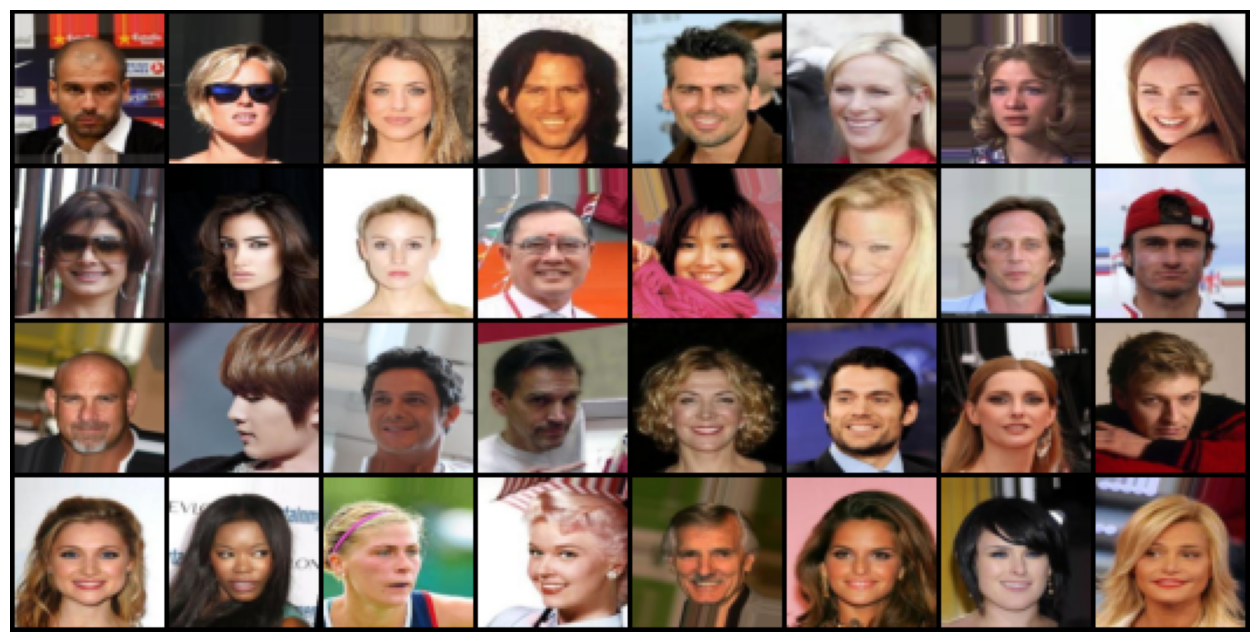

In [6]:
def imshow(img):
    img = img.numpy().transpose((1, 2, 0))
    plt.figure(figsize=(16, 16))
    plt.imshow(img)
    plt.axis('off')
    plt.show()

images, _ = next(iter(dataloader))
imshow(torchvision.utils.make_grid(images))

In [66]:
class Discriminator(nn.Module):
    def __init__(self, in_channels, num_channels):
        super(Discriminator, self).__init__()
        self.in_channels = in_channels
        self.num_channels = num_channels

        self.net = nn.Sequential(
            nn.Conv2d(in_channels, num_channels, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(num_channels, 2*num_channels, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(2*num_channels, 4*num_channels, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(4*num_channels, 8*num_channels, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(8*num_channels, 1, kernel_size=4, stride=1, padding=0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        print(x.shape)
        x = self.net(x)
        print(x.shape)
        return x.view(-1, 1)

image = next(iter(dataloader))[0][0]
discriminator = Discriminator(3, 8)
out = discriminator(image)

torch.Size([3, 64, 64])
torch.Size([1, 1, 1])
